# 🐾 Step 8-9: Train the Model

In this notebook, we will:
1. Set up data generators
2. Build and compile the model
3. Add callbacks (early stopping, checkpoints)
4. Train the model
5. Visualize training progress

## 8.1 Setup Everything

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 3
EPOCHS = 300  # Maximum epochs (early stopping will stop if needed)

# Paths
DATA_DIR = "../../data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VALID_DIR = os.path.join(DATA_DIR, "valid")

# Create models folder
os.makedirs("../../models", exist_ok=True)

print(f"TensorFlow version: {tf.__version__}")
print(f"Training for max {EPOCHS} epochs")

TensorFlow version: 2.20.0
Training for max 300 epochs


## 8.2 Prepare Data Generators

In [11]:
# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

# Validation data - no augmentation
valid_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print(f"\nClass mapping: {train_generator.class_indices}")

Found 206 images belonging to 4 classes.
Found 46 images belonging to 4 classes.

Class mapping: {'domestic_cat': 0, 'domestic_dog': 1, 'european_badger': 2, 'mule_deer': 3}


## 8.3 Build the Model

In [12]:
# Build our simple CNN
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    
    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Classification head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

## 8.4 Set Up Callbacks

Callbacks are helpful tools that run during training:

| Callback | What it does |
|----------|-------------|
| **EarlyStopping** | Stops training when model stops improving |
| **ModelCheckpoint** | Saves the best model during training |

In [13]:
# Early stopping: stop if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',      # Watch validation loss
    patience=5,              # Wait 5 epochs before stopping
    restore_best_weights=True  # Keep the best weights
)

# Model checkpoint: save the best model
checkpoint = ModelCheckpoint(
    '../../models/best_model.keras',  # Save path
    monitor='val_accuracy',        # Watch validation accuracy
    save_best_only=True,           # Only save if it's the best
    verbose=1
)

callbacks = [early_stopping, checkpoint]
print("Callbacks ready!")

Callbacks ready!


## 8.5 Train the Model! 🚀

This is where the learning happens. The model will:
1. Look at batches of training images
2. Make predictions
3. Calculate how wrong it was (loss)
4. Adjust its weights to do better next time

In [14]:
# Train the model
print("Starting training...")
print("="*50)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=callbacks
)

print("="*50)
print("Training complete!")

Starting training...
Epoch 1/300


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 4), output.shape=(None, 3)

## 8.6 Visualize Training Progress

Let's see how the model learned over time.

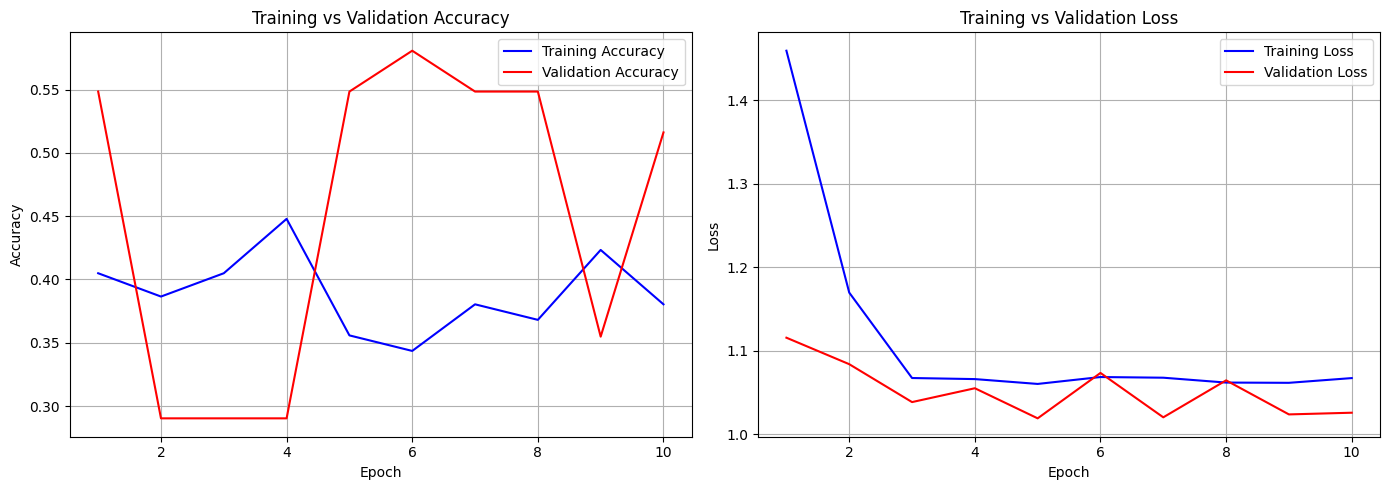


Final Training Accuracy: 38.04%
Final Validation Accuracy: 51.61%


In [ ]:
# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(epochs_range, acc, 'b-', label='Training Accuracy')
ax1.plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
ax1.set_title('Training vs Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(epochs_range, loss, 'b-', label='Training Loss')
ax2.plot(epochs_range, val_loss, 'r-', label='Validation Loss')
ax2.set_title('Training vs Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('../../models/training_history.png', dpi=150)
plt.show()

print(f"\nFinal Training Accuracy: {acc[-1]:.2%}")
print(f"Final Validation Accuracy: {val_acc[-1]:.2%}")

## 8.7 Understanding the Plots

**What to look for:**

| Pattern | Meaning |
|---------|--------|
| Both lines go up together | ✅ Good! Model is learning |
| Training high, validation low | ⚠️ Overfitting - model memorized training data |
| Both lines flat/low | ❌ Model not learning - try different settings |
| Lines converge | ✅ Training is complete |

In [ ]:
# Save the final model
model.save('../models/footprint_classifier.keras')
print("Model saved to ../models/footprint_classifier.keras")

Model saved to ../models/footprint_classifier.keras


## ✅ Steps 8-9 Complete!

**What we did:**
- Trained the CNN on our footprint images
- Used callbacks to prevent overfitting and save the best model
- Visualized the training progress

**For your presentation:**
- "We trained for X epochs until the model stopped improving"
- "Early stopping prevented overfitting by stopping when validation loss increased"
- "We achieved X% accuracy on the validation set"

**Next step:** Evaluate on the test set and create confusion matrix!